## Stellar Classification

**Gustavo Adriano de Vasconcelos – 15637485**

**Paloma Barduchi Barbin – 12677641**

**Antonio Augusto dos Santos Daneze - 14558993**

Nesse projeto, vamos ensinar um modelo a reconhecer a classe do objeto baseando-se nas medições coletadas e analisar a distribuição dessas classes em Galaxias, Estrelas ou Quasares.

A base de dados é composta por 100000 linhas e 18 colunas contendo informações sobre
esses corpos, como: Identificador único do objeto (Id); Posição no céu;
Velocidade de afastamento (redshitf), etc...

- obj_ID = Identificador do Objeto, o valor único que identifica o objeto no catálogo de imagens usado pelo CAS
- alpha = Ângulo de Ascensão Reta (no epoch J2000)
- delta = Ângulo de Declinação (no epoch J2000)
- u = Filtro Ultravioleta no sistema fotométrico
- g = Filtro Verde no sistema fotométrico
- r = Filtro Vermelho no sistema fotométrico
- i = Filtro Infra-infravermelho próximo no sistema fotométrico
- z = Filtro Infravermelho no sistema fotométrico
- run_ID = Número da Varredura usado para identificar o escaneamento específico
- rerun_ID = Número de Reprocessamento que indica como a imagem foi processada
- cam_col = Coluna da câmera que identifica a linha de varredura dentro do run
- field_ID = Número do campo para identificar cada campo
- spec_obj_ID = ID único usado para objetos espectroscópicos ópticos (isso significa que duas observações diferentes com o mesmo spec_obj_ID devem compartilhar a mesma classe de saída)
- class = Classe do objeto (galáxia, estrela ou quasar)
- redshift = Valor do desvio para o vermelho baseado no aumento do comprimento de onda
- plate = ID da placa, identifica cada placa no SDSS
- MJD = Data Juliana Modificada, usada para indicar quando determinado dado do SDSS foi obtido
- fiber_ID = ID da fibra que identifica a fibra que direcionou a luz no plano focal em cada observação

O objetivo principal é criar um modelo para predizer a classificação do objeto.

In [64]:
#Bibliotecas utilizadas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Importamos o Dataset do site https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17 e fizemos o download em .csv.

In [34]:
data = pd.read_csv("star_classification.csv")
data.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


## Limpeza dos dados

Como a base de dados não apresenta nenhum valor faltante ou duplocado

In [20]:
data.isnull().sum()


obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

In [23]:
data.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
99995    False
99996    False
99997    False
99998    False
99999    False
Length: 100000, dtype: bool

Agora, verificamos a existência de outliers extremos

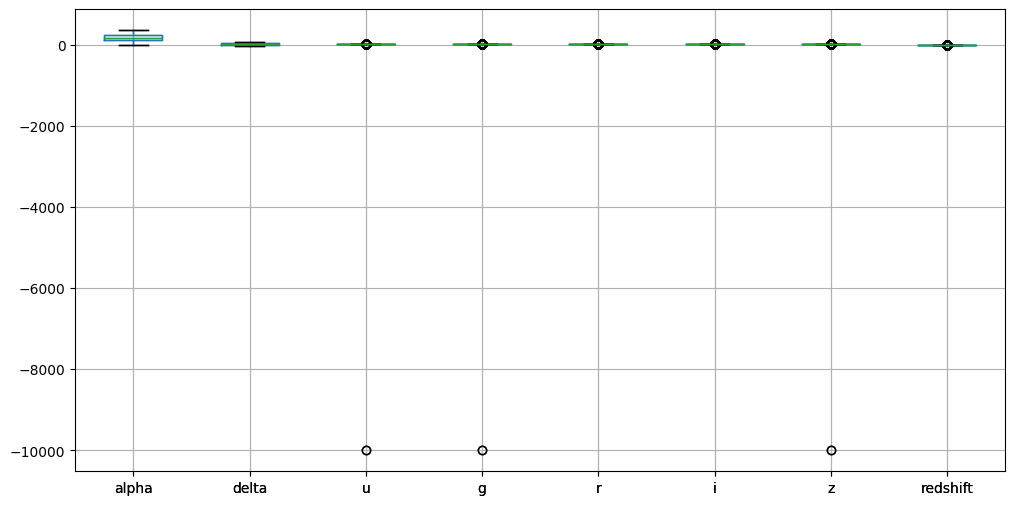

alpha: 0 outliers
delta: 0 outliers
u: 56 outliers
g: 99 outliers
r: 132 outliers
i: 198 outliers
z: 320 outliers
redshift: 8990 outliers


In [ ]:
#Remoção dos Ids para anlise exploratória
cols_to_use = ["alpha", "delta", "u", "g", "r", "i", "z", "redshift"]
data[cols_to_use].boxplot(figsize=(12,6))
plt.show()

for col in cols_to_use:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    outliers = ((data[col] < (Q1 - 1.5 * IQR)) | (data[col] > (Q3 + 1.5 * IQR))).sum()
    
    print(f"{col}: {outliers} outliers")


Embora o dataset apresente valores classificados como outliers, esses valores não representam erros ou anomalias de medição. No contexto de dados astronômicos, magnitudes fotométricas e valores de redshift possuem distribuições naturalmente amplas e assimétricas devido à variedade real de objetos observados — como estrelas muito brilhantes, galáxias fracas e quasares distantes. Esses valores extremos carregam informação física essencial para a separação entre as classes e removê-los distorceria a distribuição real dos dados. Portanto, os outliers foram mantidos por representarem fenômenos reais e relevantes.

## Histograma e gráfico de dipersão

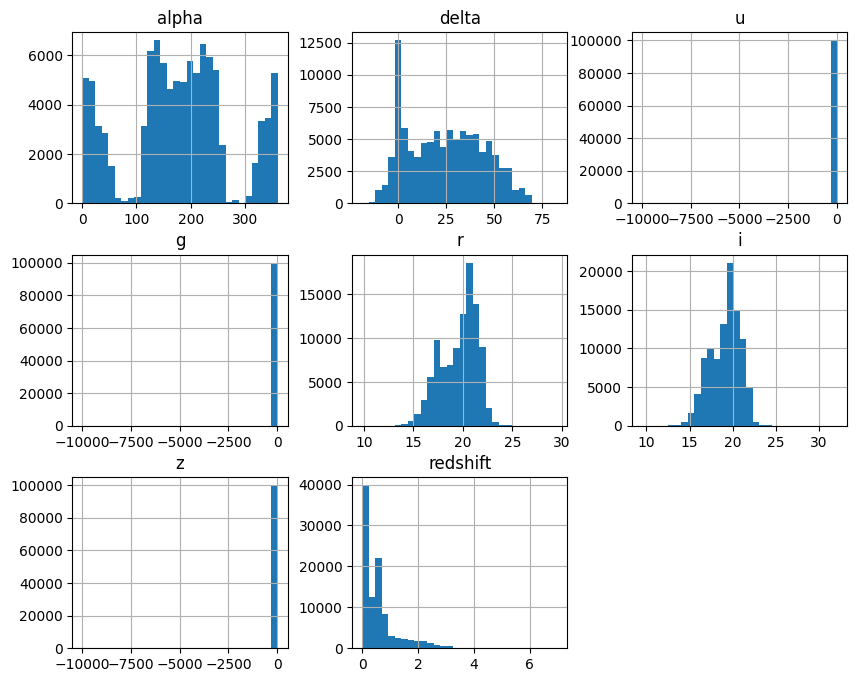

In [61]:
cols_to_drop = [
    "obj_ID", "spec_obj_ID", "run_ID", "rerun_ID", 
    "cam_col", "field_ID", "plate", "MJD", "fiber_ID"
]
data_clean = data.drop(columns=cols_to_drop)
data_clean.hist(figsize=(10,8), bins=30)
plt.show()

Os histogramas mostram que as coordenadas astronômicas (alpha e delta) apresentam distribuições consistentes com a cobertura observacional do SDSS. As bandas fotométricas (u, g, r, i, z) exibem distribuições típicas de magnitudes astronômicas, com maior concentração em faixas específicas e alguns valores extremos esperados para objetos muito brilhantes. Já o redshift apresenta forte assimetria, com muitos objetos próximos e poucos muito distantes, refletindo a estrutura natural do catálogo. No geral, as distribuições são fisicamente coerentes e não indicam anomalias nos dados.


## Matriz de correlação

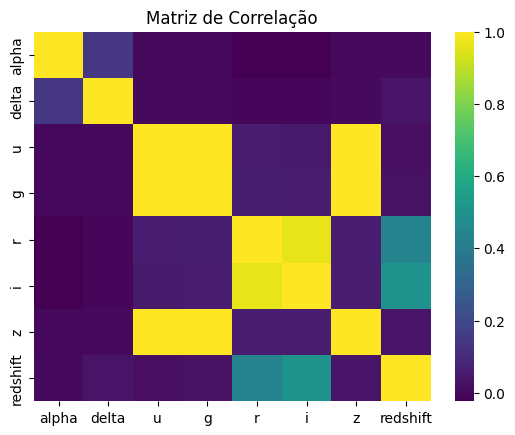

,alpha,delta,u,g,r,i,z,redshift
alpha,1.000000,0.138691,-0.001532,-0.002423,-0.022083,-0.023580,-0.002918,0.001667
delta,0.138691,1.000000,0.002074,0.003523,-0.006835,-0.004480,0.003630,0.031638
u,-0.001532,0.002074,1.000000,0.999311,0.054149,0.045730,0.998093,0.014309
g,-0.002423,0.003523,0.999311,1.000000,0.062387,0.056271,0.999161,0.022954
r,-0.022083,-0.006835,0.054149,0.062387,1.000000,0.962868,0.053677,0.433241
i,-0.023580,-0.004480,0.045730,0.056271,0.962868,1.000000,0.055994,0.492383
z,-0.002918,0.003630,0.998093,0.999161,0.053677,0.055994,1.000000,0.030380
redshift,0.001667,0.031638,0.014309,0.022954,0.433241,0.492383,0.030380,1.000000


In [67]:
corr = data_clean.corr(numeric_only=True)
plt.figure()
sns.heatmap(corr, cmap='viridis', annot=False)
plt.title("Matriz de Correlação")
plt.show()
corr

A matriz de correlação mostra forte relação entre as bandas fotométricas (especialmente g, r e i), refletindo a natureza contínua do espectro estelar. O redshift apresenta correlação moderada com bandas ópticas, enquanto alpha e delta não se correlacionam com nenhuma variável física, como esperado. No geral, as correlações são fisicamente coerentes e não indicam problemas nos dados.